In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# 两列，分别为节点id，节点类别
group = pd.read_csv('http://mirror.coggle.club/dataset/graph-wiki/group.txt.zip', sep='\t', header=None)

# 两列，分别为出发节点id，目的节点id
graph = pd.read_csv('http://mirror.coggle.club/dataset/graph-wiki/graph.txt.zip', sep='\t', header=None)

In [2]:
import random
# deepwalk算法就是把每个节点按照walk_length的设定随机选择节点的邻居，最终会形成每个节点的walk length长度的一个邻居串，相当于一条有关联关系的分词组成的串
def deepwalk(G, walk_length):
    nodes = G.nodes()
    history_walks = []

    # 对于每个节点
    for node in nodes:

        # 从当前节点开始
        random_walk_length = [node]

        # 开始游走
        for i in range(walk_length-1):

            # 找到节点邻居
            neighbors = list(G.neighbors(node))

            # 排除已经游走的邻居
            neighbors = list(set(neighbors) - set(random_walk_length))    
            if len(neighbors) == 0:
                break

            # 随机挑选邻居
            random_neighbor = random.choice(neighbors)            
            random_walk_length.append(random_neighbor)

            # 从下一个邻居继续游走
            node = random_neighbor

        # 此节点的游走路径
        history_walks.append(random_walk_length)

    return history_walks

In [3]:
# 步骤1：使用DeepWalk对Wiki数据集节点嵌入，维度为50维
g = nx.DiGraph()
# 构件图
g.add_edges_from(graph.values[:])
# 游走
history_walks = deepwalk(g, 100)

from gensim.models import Word2Vec
# 训练word2vec
w2v = Word2Vec(history_walks, vector_size=50, window=5)

In [58]:
node_group = group.iloc[list(w2v.wv.key_to_index.keys())][1].values

In [10]:
# 步骤2：每个group中20%的节点作为验证集，剩余的作为训练集
# 步骤3：使用节点嵌入向量 + 逻辑回归进行训练，并记录验证集准确率
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# stratify指的是按照哪个列进行切分最终分开的数据类别与原数据集保持一致
x_train,x_valid,y_train,y_valid = train_test_split(w2v.wv.vectors, node_group, test_size=0.2, stratify=node_group)
model = LogisticRegression()
model.fit(x_train,y_train)
model.score(x_valid, y_valid)

0.5301204819277109

In [15]:
from tqdm import tqdm
# 步骤4：使用node2vec重复上述操作
# node2vec相当于依据每个节点游走的概率值为基础进行随机游走，生成每个节点num_steps长度的节点序列，作为一个类似于句子的数据。最终相当于生成了一个句子列表
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(1 / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(1)
        else:
            # Control the probability to move forward.
            weights.append(1 / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]

    if len(neighbors) == 0:
        return None

    # Probabilistically select a neighbor to visit.    
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(nodes):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                if next:
                    walk.append(next)
                else:
                    break
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

In [16]:
g = nx.DiGraph()
g.add_edges_from(graph.values[:])
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 4
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 100
# 游走结果
walks = random_walk(g, num_walks, num_steps, p, q)

100%|█████████████████████████████████████████████████████████████████████████████| 2405/2405 [00:08<00:00, 275.64it/s]


In [21]:
w2v_node2vec = Word2Vec(walks, vector_size=50, window=5)

In [22]:
node_group_node2vec = group.iloc[list(w2v_node2vec.wv.key_to_index.keys())][1].values

In [24]:
len(w2v_node2vec.wv.vectors),len(node_group_node2vec)

(2405, 2405)

In [32]:
x_train_n2v,x_valid_n2v,y_train_n2v,y_valid_n2v = train_test_split(w2v_node2vec.wv.vectors, node_group_node2vec, test_size=0.2, stratify=node_group_node2vec)
model = LogisticRegression(random_state=0,max_iter=150)
model.fit(x_train_n2v,y_train_n2v)
model.score(x_valid_n2v, y_valid_n2v)

0.5550935550935551

In [61]:
# 步骤5：使用t-SNE将节点的DeepWalk/node2vec特征降维，绘制散点图，节点颜色使用group进行区分
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(w2v.wv.vectors)

G:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
G:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


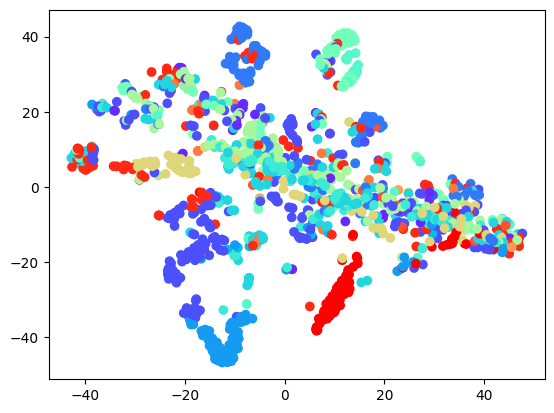

In [63]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 20))#20个类
plt.scatter(
    tsne_data[:, 0], 
    tsne_data[:, 1],
    color=colors[node_group]
)

In [64]:
tsne_n2v = TSNE(n_components=2)
tsne_data_n2v = tsne_n2v.fit_transform(w2v_node2vec.wv.vectors)

G:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
G:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


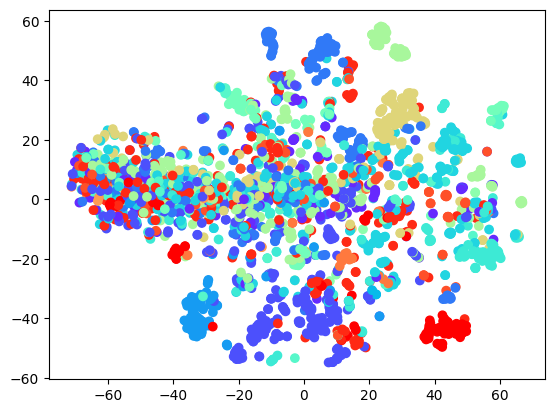

In [66]:
colors = cm.rainbow(np.linspace(0, 1, 20))#20个类
plt.scatter(
    tsne_data_n2v[:, 0], 
    tsne_data_n2v[:, 1],
    color=colors[node_group_node2vec]
)